# How to access open Earth observation training data
**Assessment Two**

## Introduction
In this notebook, you will convert your image files  the [TIFF](https://en.wikipedia.org/wiki/TIFF) format, the preferred format for storing geospatial data, raster graphics etc.

## Upload Images to Colab


Upload any 13 images of the same location i.e. any 13 images in the same folder.  For example, if you downloaded the images using the Notebook given during the course and saved it in the same folder as the Notebook, browse to **crop_data/images/2019-10-14** and upload all the images in this folder to Google Colab. 

Use the tutorial below to see how to upload images to Google Colab from your hard drive: https://tinyurl.com/y5y6ztdw

## Install rasterio Library

In [ ]:
!pip install rasterio

## Import Required Libraries

In [ ]:
#import required libraries
import rasterio
from rasterio import plot
import matplotlib.pyplot as plt
%matplotlib inline

## File Conversion to TIFF and Display

There are many more libraries to manipulate Tiff files than there are for JP2 files. Hence it is critical to learn how to convert JP2 files to Tiff files. In the next cell, you will convert JP2 files to Tiff files and then view them. You will create two Tiff images i.e. one image with bands 3, 4, and 5 and another image with bands 3, 4 and 8.



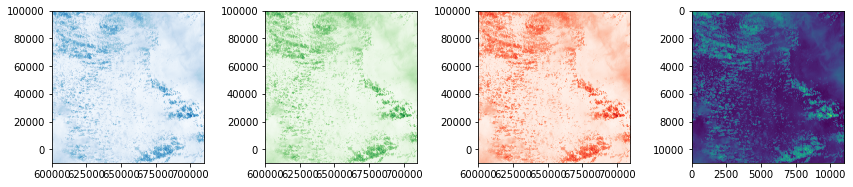

In [ ]:
# Import bands as separate 1 band raster
imagePath = './'
band2 = rasterio.open('./B02.jp2', driver='JP2OpenJPEG') # import BO2.jp2 as band2 ( this is the blue band)
band3 = rasterio.open('./B03.jp2', driver='JP2OpenJPEG') # import BO3.jp2 as band3 ( this is the green band)
band4 = rasterio.open(imagePath+'B04.jp2', driver='JP2OpenJPEG') # import BO4.jp2 as band4 ( this is the red band)
band8 = rasterio.open(imagePath+'B08.jp2', driver='JP2OpenJPEG') # import BO8.jp2 as band8 ( this is the near infrared (NIR) band)
bandtci = rasterio.open(imagePath+'TCI.jp2', driver='JP2OpenJPEG') #import TCI.jp2 as bandtci (this is the true color image)

# Display the images 
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 5))
plot.show(band2, ax=ax1, cmap='Blues')
plot.show(band3, ax=ax2, cmap='Greens')
plot.show(band4, ax=ax3, cmap='Reds')
plot.show(bandtci, ax=ax4, cmap='tab20c')
fig.tight_layout()

# Combine 3 bands i.e. red, green and blue and then export the outcome as tiff 
# image named RGB.tiff
rgb_image = rasterio.open('./RGB.tiff','w',driver='Gtiff',
                         width=band4.width, height=band4.height,
                         count=3,
                         crs=band4.crs,
                         transform=band4.transform,
                         dtype=band4.dtypes[0]
                         )
rgb_image.write(band2.read(1),3) #blue
rgb_image.write(band3.read(1),2) #green
rgb_image.write(band4.read(1),1) #red
rgb_image.close()
rgb_image = rasterio.open(r"./RGB.tiff", count=3)
plot.show(rgb_image.read(1)) # display the image RGB.tiff





In [ ]:
# Combine 3 bands i.e blue, green, near infrared bands and then export the 
# resulting image as BGN.tiff
bgn_image = rasterio.open('./BGN.tiff', 'w', driver='Gtiff',
                          width=band2.width, height=band2.height,
                          count=3,
                          crs=band2.crs,
                          transform=band2.transform,
                          dtype='uint16'                   
                         )
# Display the individual band images
bgn_image.write(band8.read(1),3) #Visible and Near Infrared
bgn_image.write(band4.read(1),2) #Green
bgn_image.write(band3.read(1),1) #Blue
bgn_image.close()

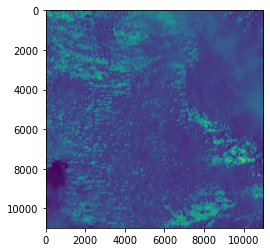

In [ ]:
# display the combined tiff image
bgn_image = rasterio.open(r"./BGN.tiff", count=3)
plot.show(bgn.read(1))

## Reference
https://www.hatarilabs.com/ih-en/sentinel2-images-explotarion-and-processing-with-python-and-rasterio